In [1]:
import re
from typing import List
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

# Make sure you've done this once in your environment:
# import nltk
# nltk.download("stopwords")

STOPWORDS = set(stopwords.words("english"))

def clean_text(text: str) -> str:
    """
    Remove punctuation except apostrophes inside words.
    Keep words inside parentheses, but drop the parentheses themselves.
    """
    # Remove parentheses but keep what's inside
    text = text.replace("(", "").replace(")", "")
    # Remove other punctuation except apostrophes inside contractions
    text = re.sub(r"[^\w\s']+", " ", text)
    return text

def tokenize_keep_contractions(text: str) -> List[str]:
    """
    Tokenize text into lowercase tokens while preserving contractions.
    """
    tknzr = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
    return tknzr.tokenize(text)

def preprocess_lyrics(raw_text: str) -> List[str]:
    """
    Steps:
      1. remove punctuation (but keep apostrophes inside words)
      2. tokenize (keeps contractions)
      3. remove NLTK stopwords automatically
    Returns: list of tokens.
    """
    text = clean_text(raw_text)
    tokens = tokenize_keep_contractions(text)
    tokens = [t for t in tokens if t.lower() not in STOPWORDS]
    return tokens


# -------- Example --------
if __name__ == "__main__":
    raw = """your's got a house made of glass
got his own swimming pool
(what a gas)
what about us
don't wanna cause no fuss
but what about us"""

    tokens = preprocess_lyrics(raw)
    print(tokens)


["your's", 'got', 'house', 'made', 'glass', 'got', 'swimming', 'pool', 'gas', 'us', 'wanna', 'cause', 'fuss', 'us']


In [2]:
from collections import Counter

def count_swears(tokens):
    # allowed ass variants
    ass_variants = {
        "ass", "asshole", "assholes", "asswipe", "asshat", "jackass", "jackasses",
        "dumbass", "smartass", "badass", "hardass", "lameass"
    }

    counts = Counter({s: 0 for s in ['shit', 'bitch', 'damn', 'dick', 'fuck', 'ass', 'hell']})

    for tok in tokens:
        t = tok.lower()

        if "fuck" in t:  # fuck, fucking, motherfucker, etc.
            counts["fuck"] += 1

        elif t in ass_variants:
            counts["ass"] += 1

        elif t.startswith("shit"):  # shit, shits, shitty, shithead
            counts["shit"] += 1

        elif t.startswith("bitch"):  # bitch, bitches, bitching
            counts["bitch"] += 1

        elif "damn" in t:  # damn, goddamn, damned, dammit
            counts["damn"] += 1

        elif t.startswith("dick"):  # dick, dicks, dickhead
            counts["dick"] += 1

        elif t.startswith("hell"):  # hell, hellish, etc.
            counts["hell"] += 1

    return counts

In [3]:
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
from zipfile import ZipFile
import pickle
import numpy as np
import seaborn as sb
import json
import plotly.graph_objects as go



    
def create_data():
	with ZipFile('data1 (2).zip', 'r') as f:
	    # Extract all contents in the current directory
	    f.extractall()
	
	    # Open the .pkl file inside the zip
	    with f.open('data1.pkl') as pkl_file:
	        # Load the pickle data
	        data1 = pd.read_pickle(pkl_file)
	
	# Open the .zip file
	with ZipFile('data2.zip', 'r') as f:
	    # Extract all contents in the current directory
	    f.extractall()
	
	    # Open the .pkl file inside the zip
	    with f.open('data2.pkl') as pkl_file:
	        # Load the pickle data
	        data2 = pd.read_pickle(pkl_file)
	
	# Open the .zip file
	with ZipFile('data3.zip', 'r') as f:
	    # Extract all contents in the current directory
	    f.extractall()
	
	    # Open the .pkl file inside the zip
	    with f.open('data3.pkl') as pkl_file:
	        # Load the pickle data
	        data3 = pd.read_pickle(pkl_file)
	
	# Open the .zip file
	with ZipFile('data4.zip', 'r') as f:
	    # Extract all contents in the current directory
	    f.extractall()
	
	    # Open the .pkl file inside the zip
	    with f.open('data4.pkl') as pkl_file:
	        # Load the pickle data
	        data4 = pd.read_pickle(pkl_file)


	final = pd.concat([data1, data2, data3, data4])
	final = pd.concat([final.iloc[:,0:6], final.iloc[:,11:]], axis = 1)

	return final


final = create_data()


In [4]:
unique = final.drop_duplicates(subset = ['title', 'artist'])
unique = unique.iloc[:, :9]
unique = unique.reset_index(drop = True)
unique

,title,artist,rank,date,cleaned_lyrics,tokens,tot_words,unique_words,percent_unique
0,What About Us,The Coasters,50,1960-01-04,he's got a house made of glass\ngot his own sw...,"[he, 's, got, a, house, made, of, glass, got, ...",274,89,0.324818
1,Swingin' On A Rainbow,Frankie Avalon,39,1960-01-04,you've got me swinginon a rainbow\nwalkinaroun...,"[you, 've, got, me, swinginon, a, rainbow, wal...",184,77,0.418478
2,Misty,Johnny Mathis,40,1960-01-04,look at me\ni'm as helpless as a kitten up a t...,"[look, at, me, i, 'm, as, helpless, as, a, kit...",145,83,0.572414
3,He'll Have To Go,Jim Reeves,41,1960-01-04,put your sweet lips a little closer to the pho...,"[put, your, sweet, lips, a, little, closer, to...",167,71,0.42515
4,Believe Me,Royal Teens,42,1960-01-04,each night as i go wandering\ndown the street ...,"[each, night, as, i, go, wandering, down, the,...",174,67,0.385057
...,...,...,...,...,...,...,...,...,...
23832,Beep Beep,Nicki Minaj,74,2023-12-30,(murda on the beat so it's not nice)\nayo\ni d...,"[(, murda, on, the, beat, so, it, 's, not, nic...",210,110,0.52381
23833,Bellakeo,Peso Pluma & Anitta,71,2023-12-30,salió de su casa con la mente encendida\nhoy d...,"[salió, de, su, casa, con, la, mente, encendid...",341,138,0.404692
23834,Needle,Nicki Minaj Featuring Drake,65,2023-12-30,i mean\ni don't know if i like girls\ni saw sh...,"[i, mean, i, do, n't, know, if, i, like, girls...",634,222,0.350158
23835,One Of The Girls,"The Weeknd, Jennie & Lily Rose Depp",100,2023-12-30,lock me up and throw away the key\nhe knows ho...,"[lock, me, up, and, throw, away, the, key, he,...",432,124,0.287037


In [5]:
final = final.iloc[:, :4]

In [8]:
unique['tokens'] = [preprocess_lyrics(t) for t in unique['cleaned_lyrics']]
num_swears = [count_swears(tokens) for tokens in unique['tokens']]
# Convert list of Counters into a DataFrame
swear_df = pd.DataFrame(num_swears)
df = pd.concat([unique, swear_df], axis = 1)

In [9]:
final = pd.merge(final, df, left_on=['title', 'artist'], right_on=['title', 'artist'],)

In [30]:
final['tot_words'] = [len(tokens) for tokens in final['tokens']]
final['unique_words'] = [len(set(tokens)) for tokens in final['tokens']]
final['percent_unique'] = final['unique_words'] / final['tot_words']
final['total_swear'] = final.iloc[:,-7:].sum(axis = 1)
f = final
f['percent_swear'] = f['total_swear'] / f['tot_words']
f['percent_swear_unique_words'] = f['total_swear'] / f['unique_words']

In [31]:
f = f.rename({'rank_x':'rank', 'date_x':'date'}, axis = 1)

In [32]:
f = f.drop(['rank_y' , 'date_y'], axis=1)

In [35]:
f = f[f['date'] > '1980']

In [156]:
swears = ['shit', 'bitch', 'damn','dick', 'fuck', 'ass', 'hell']

### Unique Swears Songs

In [38]:
unique = df
unique['total_swear'] = unique.iloc[:,-7:].sum(axis = 1)
unique

,title,artist,rank,date,cleaned_lyrics,tokens,tot_words,unique_words,percent_unique,shit,bitch,damn,dick,fuck,ass,hell,total_swear
0,What About Us,The Coasters,50,1960-01-04,he's got a house made of glass\ngot his own sw...,"[got, house, made, glass, got, swimming, pool,...",274,89,0.324818,0,0,0,0,0,0,0,0
1,Swingin' On A Rainbow,Frankie Avalon,39,1960-01-04,you've got me swinginon a rainbow\nwalkinaroun...,"[got, swinginon, rainbow, walkinaround, rain, ...",184,77,0.418478,0,0,0,0,0,0,0,0
2,Misty,Johnny Mathis,40,1960-01-04,look at me\ni'm as helpless as a kitten up a t...,"[look, helpless, kitten, tree, feel, like, cli...",145,83,0.572414,0,0,0,0,0,0,1,1
3,He'll Have To Go,Jim Reeves,41,1960-01-04,put your sweet lips a little closer to the pho...,"[put, sweet, lips, little, closer, phone, let'...",167,71,0.42515,0,0,0,0,0,0,0,0
4,Believe Me,Royal Teens,42,1960-01-04,each night as i go wandering\ndown the street ...,"[night, go, wandering, street, tears, think, l...",174,67,0.385057,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23832,Beep Beep,Nicki Minaj,74,2023-12-30,(murda on the beat so it's not nice)\nayo\ni d...,"[murda, beat, nice, ayo, drop, bag, rolls, tem...",210,110,0.52381,0,2,0,0,1,1,0,4
23833,Bellakeo,Peso Pluma & Anitta,71,2023-12-30,salió de su casa con la mente encendida\nhoy d...,"[salió, de, su, casa, con, la, mente, encendid...",341,138,0.404692,0,0,0,0,0,0,0,0
23834,Needle,Nicki Minaj Featuring Drake,65,2023-12-30,i mean\ni don't know if i like girls\ni saw sh...,"[mean, know, like, girls, saw, sheila, seraphi...",634,222,0.350158,0,2,1,0,1,0,0,4
23835,One Of The Girls,"The Weeknd, Jennie & Lily Rose Depp",100,2023-12-30,lock me up and throw away the key\nhe knows ho...,"[lock, throw, away, key, knows, get, best, for...",432,124,0.287037,0,0,0,0,0,0,0,0


In [40]:
len(unique)

23837

In [42]:
print("Songs in Dataset with any swears")
len(unique[unique['total_swear'] > 0])/len(unique)

Songs in Dataset with any swears


0.2070310861266099

In [44]:
unique['total_swear'].sum()/len(unique)

1.6420271007257625

In [46]:
unique['total_swear'].sum()/(unique['total_swear'] != 0).sum()

7.931306990881459

In [48]:
unique.iloc[:, 9:-1].sum()

shit      7686
bitch     9382
damn      3104
dick      1123
fuck     11293
ass       3287
hell      3266
dtype: int64

In [50]:
unique.iloc[:, 9:-1].sum()

shit      7686
bitch     9382
damn      3104
dick      1123
fuck     11293
ass       3287
hell      3266
dtype: int64

In [52]:
non_zero_counts = (unique.iloc[:, 9:-1] != 0).sum(axis=0)
non_zero_counts

shit     2228
bitch    1945
damn     1515
dick      586
fuck     2434
ass      1249
hell     1524
dtype: int64

In [54]:
unique.iloc[:, 9:-1].sum()/(unique.iloc[:, 9:-1] != 0).sum(axis=0)

shit     3.449731
bitch    4.823650
damn     2.048845
dick     1.916382
fuck     4.639688
ass      2.631705
hell     2.143045
dtype: float64

#### Of All The Songs That Have Swears, What is the Most Common Number of Swears

In [78]:
num_swears = unique[(unique['total_swear'] > 0) & (unique['total_swear'] <= 40)]['total_swear']

In [136]:
# Make histogram with one bar per integer
import json

fig = px.histogram(
    x=num_swears,
    nbins=40,                # total number of bins
    labels={'x': 'Value', 'y': 'Count'},
    title = 'Distribution of Number of Swears in Songs That Have Swears'
)

# Force x-axis ticks from 1 to 40
#fig.update_xaxes(dtick=1, range=[0.5, 40.5])
fig.update_layout(
	xaxis_title="Number of Swears",
	yaxis_title="Number of Songs",

)

# Save figure to JSON file
with open("dist_swears.json", "w") as f:
    f.write(fig.to_json())

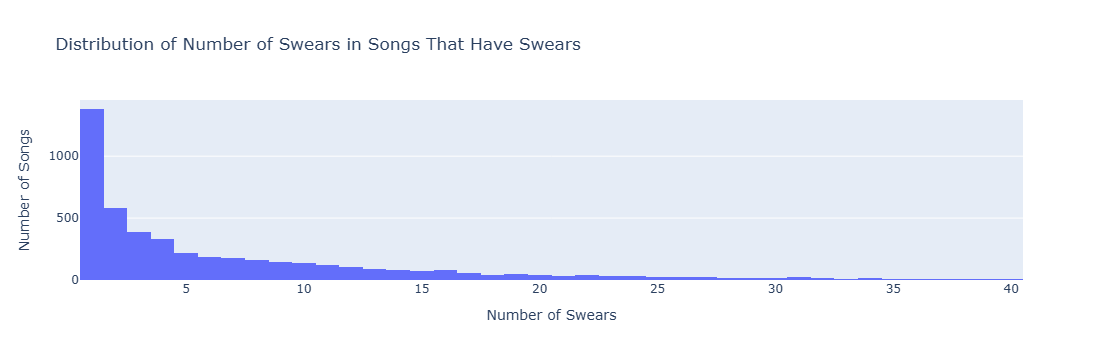

In [142]:
import plotly.io as pio

# Load figure from JSON file
with open("dist_swears.json", "r") as f:
    fig = pio.from_json(f.read())
fig

#### Most Common Swear in Songs That Only Have 1, 2, 5, 10+

In [160]:
df = pd.DataFrame(columns = (1, 2, 5, 10), index = swears)

In [166]:
for i in [1, 2, 5, 10]:
    if i == 10:
        t = unique[unique['total_swear'] >= 10]
    else:
        t = unique[unique['total_swear'] == i]
    df[i] = (t.iloc[:,-8:-1] != 0).sum(axis=0)/len(t)
    


In [182]:
df.columns = ["1", "2", "5", "10 or more"]

In [184]:
df.to_csv('dist.csv')

In [180]:
df

,1,2,5,>=10
shit,0.102824,0.243151,0.579909,0.816716
bitch,0.046343,0.128425,0.438356,0.831378
damn,0.251267,0.332192,0.283105,0.368035
dick,0.015930,0.027397,0.073059,0.295455
fuck,0.107893,0.234589,0.575342,0.901026
ass,0.060825,0.131849,0.273973,0.499267
hell,0.414917,0.345890,0.246575,0.245601


### Ranks

In [661]:
vals = pd.DataFrame(columns = ['title', 'artist', 'rank', 'total_swear', 'percent_swear'])

for row, col in f.groupby(['title', 'artist']):
    v = col.iloc[0]
    vals.loc[len(vals)] = (v.title, v.artist, (min(col['rank'])), v.total_swear, v.percent_swear)


        

In [662]:
vals.to_csv('rank_impact_on_swearing.csv')

In [680]:
dta = pd.DataFrame(columns = [1, 3, 5, 10, 15, 20], index = range(1,101))
for i in [1, 3, 5, 10, 15, 20]:
    dta[i] = vals[vals['total_swear'] >= i].groupby('rank').count()['title']/vals.groupby('rank').count()['title']

In [682]:
dta.to_csv('swear_words_by_rank.csv')

### Swearing Distribution

In [686]:
dist_data = pd.DataFrame(index = f['date'].unique(), columns = [1, 2, 5, 10])

In [688]:
for num in [1, 2, 5, 10]:
    dta = []
    for idx, data in f.groupby('date'):
        dta.append(len(data[data['total_swear'] >= num])/len(data))
    dist_data[num] = dta
    

In [690]:
dist_data.to_csv('percent_dist.csv')

In [ ]:
### Only look at swearing songs

In [103]:
f['year'] = [date.split('-')[0] for date in f['date']]
swear_only = f[f['total_swear'] > 0]
dist_data = pd.DataFrame(index = swear_only['year'].unique(), columns = [2, 5, 10, 20])
for num in [2, 5, 10, 20]:
    dta = []
    for idx, data in swear_only.groupby('year'):
        dta.append(len(data[data['total_swear'] >= num])/len(data))
    dist_data[num] = dta

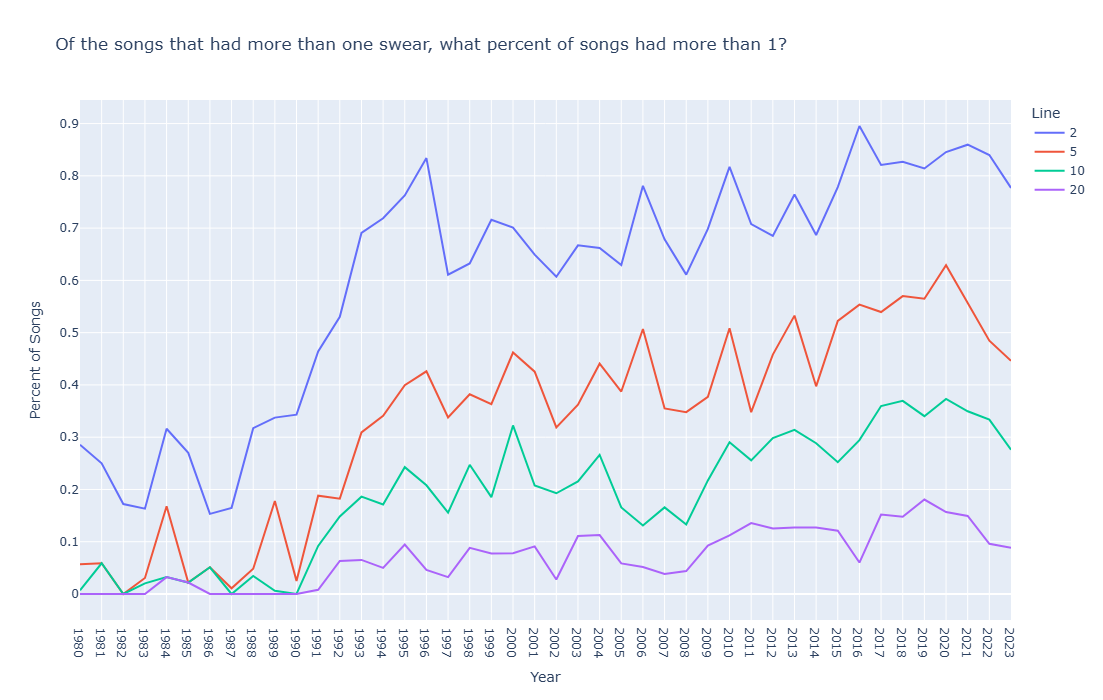

In [114]:
# Melt DataFrame to long format for Plotly
df_melted = dist_data.reset_index().melt(id_vars="index", var_name="Line", value_name="Value")

# Line plot
fig = px.line(
    df_melted,
    x="index",
    y="Value",
    color="Line",
    title="Of the songs that had more than one swear, what percent of songs had more than 1?",
    labels={"index": "X-axis", "Value": "Y-axis"}
)

fig.update_layout(
	xaxis_title="Year",
	yaxis_title="Percent of Songs",
    height = 700,
    width = 900
)

In [110]:
swear_only

,title,artist,rank,date,cleaned_lyrics,tokens,tot_words,unique_words,percent_unique,shit,bitch,damn,dick,fuck,ass,hell,total_swear,percent_swear,percent_swear_unique_words,year
41473,Rapper's Delight,Sugarhill Gang,36,1980-01-12,i said a hip-hop\nthe hippie\nthe hippie\nto t...,"[said, hip, hop, hippie, hippie, hip, hip, hop...",1497,592,0.395458,0,0,3,0,0,0,4,7,0.004676,0.011824,1980
41477,Deja Vu,Dionne Warwick,27,1980-01-12,this is insane\nall you did was say hello\nspe...,"[insane, say, hello, speak, name, feeling, lov...",115,38,0.330435,0,0,0,0,0,0,1,1,0.008696,0.026316,1980
41483,Damned If I Do,The Alan Parsons Project,47,1980-01-12,i ain't got a heart of stone\ni'm hurtinmore n...,"[ain't, got, heart, stone, hurtinmore, ever, k...",83,49,0.590361,0,0,10,0,0,0,0,10,0.120482,0.204082,1980
41502,Wonderland,Commodores,54,1980-01-12,hello\nhoney\nthis is your lucky day\ni've com...,"[hello, honey, lucky, day, come, take, far, fa...",91,62,0.681319,0,0,0,0,0,0,1,1,0.010989,0.016129,1980
41536,Looks Like Love Again,Dann Rogers,60,1980-01-12,some say love is a losingame\nwaitinto steal y...,"[say, love, losingame, waitinto, steal, away, ...",112,56,0.500000,0,0,0,0,0,0,1,1,0.008929,0.017857,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148750,Thinkin' Bout Me,Morgan Wallen,37,2023-12-30,don't know where you at\ndon't know where you'...,"[know, know, know, nothinbout, boy, feel, bad,...",157,62,0.394904,0,0,1,0,0,0,1,2,0.012739,0.032258,2023
148752,Last Night,Morgan Wallen,33,2023-12-30,last night\nwe let the liquor talk\ni can't re...,"[last, night, let, liquor, talk, can't, rememb...",187,71,0.379679,2,0,0,0,0,0,1,3,0.016043,0.042254,2023
148756,Agora Hills,Doja Cat,29,2023-12-30,ooh\nyeah\nyeah\nkissinand hope they caught us...,"[ooh, yeah, yeah, kissinand, hope, caught, us,...",326,155,0.475460,2,0,1,2,5,1,0,11,0.033742,0.070968,2023
148757,I Remember Everything,Zach Bryan Featuring Kacey Musgraves,28,2023-12-30,rotgut whiskey's gonna ease my mind\nbeach tow...,"[rotgut, whiskey's, gonna, ease, mind, beach, ...",170,84,0.494118,0,0,0,0,0,0,2,2,0.011765,0.023810,2023


In [692]:
### DO BY MONTH

In [694]:
f['month'] = [int(date.split('-')[1]) for date in f['date']]

C:\Users\gouth\AppData\Local\Temp\ipykernel_59036\3929627262.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [696]:
dist_data = pd.DataFrame(index =[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
], columns = [1, 2, 5, 10])
for num in [1, 2, 5, 10]:
    dta = []
    for idx, data in f.groupby('month'):
        dta.append(len(data[data['total_swear'] >= num])/len(data))
    dist_data[num] = dta

In [698]:
dist_data

,1,2,5,10
January,0.280570,0.204526,0.123042,0.072563
February,0.288076,0.208665,0.127203,0.074463
March,0.294808,0.209676,0.126868,0.074172
April,0.296440,0.212490,0.130816,0.075987
May,0.287667,0.205775,0.125427,0.073515
June,0.280831,0.199069,0.121962,0.071883
July,0.291598,0.206028,0.123330,0.073093
August,0.276869,0.196070,0.115051,0.064881
September,0.286153,0.206963,0.120605,0.067471
October,0.286894,0.210280,0.127690,0.071398


### Which Swear

In [706]:
f['year'] = [date.split('-')[0] for date in f['date']]

C:\Users\gouth\AppData\Local\Temp\ipykernel_59036\1368771250.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [710]:
# How many songs does it appear in
which_swear = pd.DataFrame(columns = swears)
for idx, data in f.groupby('year'):
    for s in swears:
        which_swear.loc[idx, s] = ((data[s] != 0).sum()/len(data))
    

In [712]:
which_swear.to_csv('which_swear.csv')

In [714]:
which_swear = pd.read_csv('which_swear.csv', index_col=0)

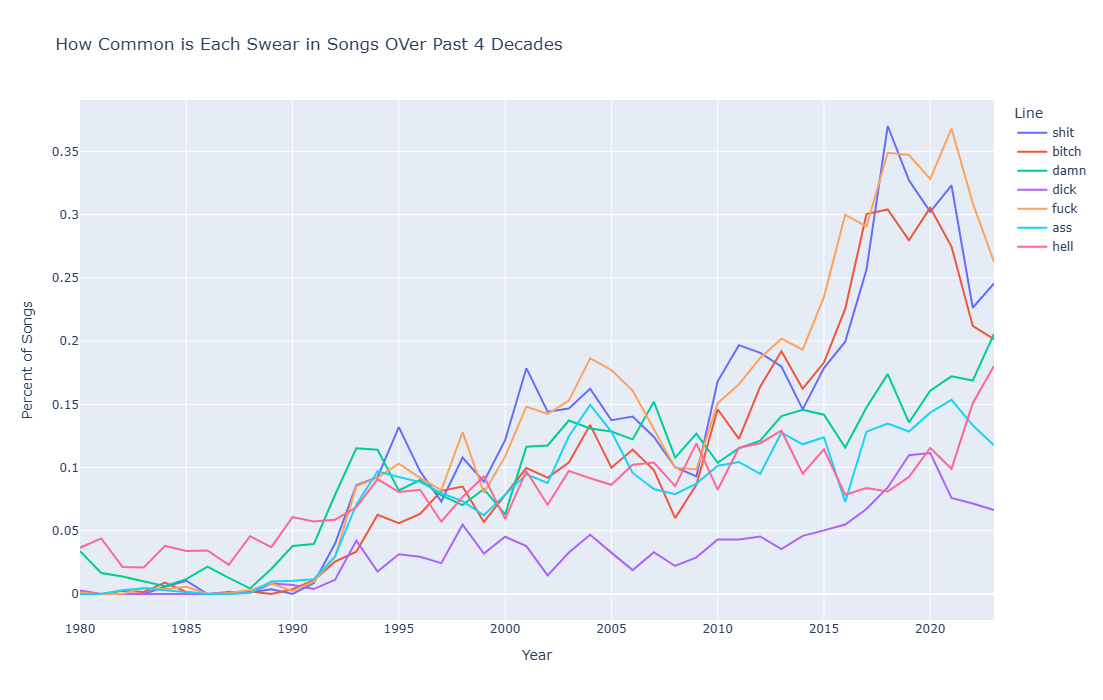

In [734]:
# Melt DataFrame to long format for Plotly
df_melted = which_swear.reset_index().melt(id_vars="index", var_name="Line", value_name="Value")

# Line plot
fig = px.line(
    df_melted,
    x="index",
    y="Value",
    color="Line",
    title="How Common is Each Swear in Songs OVer Past 4 Decades",
    labels={"index": "X-axis", "Value": "Y-axis"}
)

fig.update_layout(
	xaxis_title="Year",
	yaxis_title="Percent of Songs",
    height = 700,
    width = 900
)

In [736]:
### Top song each year

In [750]:
data = pd.DataFrame(columns = f.columns)
for idx, dta in f.groupby('year'):
    row = dta.loc[dta["total_swear"].idxmax()]
    data.loc[idx] = row

In [760]:
data = data.drop(['date', 'cleaned_lyrics', 'tokens', 'unique_words', 'percent_unique', 'percent_swear_unique_words', 'month', 'year'], axis = 1)

In [764]:
data.to_csv('most_byyear.csv')

In [768]:
pd.read_csv('most_byyear.csv', index_col = 0)

,title,artist,rank,tot_words,shit,bitch,damn,dick,fuck,ass,hell,total_swear,percent_swear
1980,Damned If I Do,The Alan Parsons Project,47,83,0,0,10,0,0,0,0,10,0.120482
1981,Hello Again,Neil Diamond,25,58,0,0,0,0,0,0,12,12,0.206897
1982,Valley Girl,Frank Zappa,62,471,0,4,0,0,0,0,0,4,0.008493
1983,Memphis,Joe Jackson,94,150,0,0,0,0,0,0,10,10,0.066667
1984,Hello Again,The Cars,60,108,0,0,0,0,0,0,31,31,0.287037
1985,Hello Again,The Cars,28,108,0,0,0,0,0,0,31,31,0.287037
1986,Vienna Calling,Falco,70,418,0,0,0,0,0,0,19,19,0.045455
1987,Niagara Falls,Chicago,91,94,0,0,0,0,0,0,6,6,0.063830
1988,Girls Ain't Nothing But Trouble,D.J. Jazzy Jeff & The Fresh Prince,79,468,0,0,0,0,0,0,10,10,0.021368
1989,Girls Ain't Nothing But Trouble,D.J. Jazzy Jeff & The Fresh Prince,92,468,0,0,0,0,0,0,10,10,0.021368
